# Point-in-polygon queries

Finding out if a certain point is located inside or outside of an area,
or finding out if a line intersects with another line or polygon are
fundamental geospatial operations that are often used e.g. to select
data based on location. Such spatial queries are one of the typical
first steps of the workflow when doing spatial analysis. Performing a
spatial join (will be introduced later) between two spatial datasets is
one of the most typical applications where Point in Polygon (PIP) query
is used.

For further reading about PIP and other geometric operations,
see Chapter 4.2 in Smith, Goodchild & Longley: [Geospatial Analysis - 6th edition](https://www.spatialanalysisonline.com/HTML/index.html).


## How to check if point is inside a polygon?

Computationally, detecting if a point is inside a polygon is most commonly done using a specific formula called [Ray Casting algorithm](https://en.wikipedia.org/wiki/Point_in_polygon#Ray_casting_algorithm).
Luckily, we do not need to create such a function ourselves for
conducting the Point in Polygon (PIP) query. Instead, we can take
advantage of [Shapely's binary predicates](https://shapely.readthedocs.io/en/stable/manual.html#binary-predicates)
that can evaluate the topolocical relationships between geographical
objects, such as the PIP as we're interested here.

## Point-in-polygon queries on `shapely` geometries

There are basically two ways of conducting PIP in Shapely:

1. using a function called
   [within()](https://shapely.readthedocs.io/en/stable/manual.html#object.within)
   that checks if a point is within a polygon
2. using a function called
   [contains()](https://shapely.readthedocs.io/en/stable/manual.html#object.contains)
   that checks if a polygon contains a point


> **Note**
>
> Even though we are discussing a **Point** in Polygon operation, it is also possible to check if a LineString or Polygon is inside another Polygon.



Let’s first create a couple of point geometries:

In [1]:
import shapely.geometry
point1 = shapely.geometry.Point(24.952242, 60.1696017)
point2 = shapely.geometry.Point(24.976567, 60.1612500)

... and a polygon:

In [2]:
polygon = shapely.geometry.Polygon(
    [
        (24.950899, 60.169158),
        (24.953492, 60.169158),
        (24.953510, 60.170104),
        (24.950958, 60.169990)
    ]
)

In [3]:
print(point1)
print(point2)
print(polygon)

POINT (24.952242 60.1696017)
POINT (24.976567 60.16125)
POLYGON ((24.950899 60.169158, 24.953492 60.169158, 24.95351 60.170104, 24.950958 60.16999, 24.950899 60.169158))


Let’s check if the points are `within()` the polygon:

In [4]:
point1.within(polygon)

True

In [5]:
point2.within(polygon)

False

It seems that the first point is inside the polygon, but the second one is not.

We can turn the logic of the look-up around: Rather than check of the point is
within the polygon, we can also ask whether the polygon `contains()` the point:

In [6]:
polygon.contains(point1)

True

In [7]:
polygon.contains(point2)

False

> **Hint:** The two ways of checking the spatial relationship are complementary and yield
> equivalent results; [`contains()`](https://shapely.readthedocs.io/en/stable/manual.html#object.contains)
> is inverse to [`within()`](https://shapely.readthedocs.io/en/stable/manual.html#object.within),
> and vice versa.
>
> Then, which one should you use? Well, it depends:
>
> - If you have **many points and just one polygon** and want to find out which points are inside the polygon, you might need to iterate over the points and check one at a time if it is **within()** the polygon.
> - If you have **many polygons and just one point** and want to find out which polygon contains the point, you might need to iterate over the polygons until you find one that **contains()** the point.




## Point-in-polygon queries on `geopandas.GeoDataFrame`s

In the following practical example we find which of the addresses we obtained
in the [geocoding section](geocoding-in-geopandas) are located within a certain
city district of Helsinki.

The data set we are using is from [Helsinki Region Infoshare](https://hri.fi/data/en_GB/dataset/helsingin-piirijako), and licensed under a [Creative-Commons-Attribution-4.0](https://creativecommons.org/licenses/by/4.0/) license.

In [8]:
import pathlib
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"

In [9]:
import geopandas

city_districts = geopandas.read_file(
    DATA_DIRECTORY / "helsinki_city_districts" / "helsinki_city_districts_2021.gpkg"
)
city_districts.head()

,name,geometry
0,Eteläinen,"POLYGON ((24.7828 60.09996, 24.80437 60.07607,..."
1,Läntinen,"POLYGON ((24.8314 60.25406, 24.83168 60.25321,..."
2,Keskinen,"POLYGON ((24.93345 60.18317, 24.93502 60.18005..."
3,Pohjoinen,"POLYGON ((24.90081 60.23526, 24.89944 60.235, ..."
4,Koillinen,"POLYGON ((24.97163 60.24253, 24.97163 60.24246..."


<Axes: >

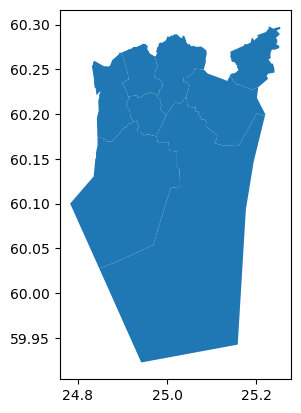

In [10]:
city_districts.plot()

Specifically, we want to find out which points are within the ‘Eteläinen’
(‘southern’) city district. Let’s start by obtaining a separate data set for
this district, loading the addresses data, and plotting a multi-layer map
that shows all districts, the ‘Eteläinen’ district, and all the points in
one map:

In [11]:
southern_district = city_districts[city_districts.name == "Eteläinen"]
southern_district

,name,geometry
0,Eteläinen,"POLYGON ((24.7828 60.09996, 24.80437 60.07607,..."


In [12]:
addresses = geopandas.read_file(DATA_DIRECTORY / "addresses.gpkg")

> **Plotting multiple map layers**
>
> To plot several map layers in one figure, use the `ax` parameter to specify in which *axes* data should be plotted. This was used in [lesson 7 of Geo-Python](https://geo-python-site.readthedocs.io/en/latest/notebooks/L7/matplotlib.html) to add text to a plot or modify axes properties.
>
> The easiest way to obtain an *axes* is to save the return value of the first `plot()` (see below). Another option is to create [`subplots()`](https://geo-python-site.readthedocs.io/en/latest/notebooks/L7/advanced-plotting.html#using-subplots), possibly with only one row and one column.


<Axes: >

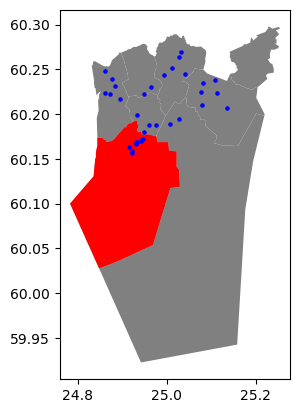

In [13]:
axes = city_districts.plot(facecolor="grey")
southern_district.plot(ax=axes, facecolor="red")
addresses.plot(ax=axes, color="blue", markersize=5)

Some points are within the ‘Eteläinen’ district, but others are not. To find
out which are the ones inside the district, we can use a **point-in-polygon
query**, this time on the entire `geopandas.GeoDataFrame`. Its method
`within()` returns Boolean (`True`/`False`) values that indicate whether or not
a row’s geometry is contained in the supplied *other* geometry:


<div style="border: 1px solid #ffa726; background-color: #ffe0b2; padding: 15px; border-radius: 5px;">

**Geometry vs. geometry column**

In the example below, we use `southern.at[0, "geometry"]` to obtain a single value, a `shapely.geometry.Polygon`, instead of an entire column (a `GeoSeries`). This ensures that each row’s geometry in the `addresses` data frame is matched against *the same polygon*. In contrast, if we ran `within()` against a column, the operation would be carried out row-wise: the first address point would be checked against the first polygon, the second address point against the second polygon, and so forth.

Check the [documentation for `within()`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.within.html) to learn more!

</div>




In [16]:
addresses.within(southern_district.at[0, "geometry"])

0      True
1      True
2      True
3     False
4      True
5     False
6     False
7     False
8     False
9     False
10     True
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30     True
31     True
32     True
33     True
dtype: bool

This list of Boolean values, also called a *mask array* can be used to filter
the input data frame:

In [17]:
addresses_in_the_southern_district = addresses[
    addresses.within(southern_district.at[0, "geometry"])
]
addresses_in_the_southern_district

,address,geometry
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",POINT (24.91556 60.1632)
1,"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",POINT (24.93166 60.16905)
2,"Social Burgerjoint, 8, Kaivokatu, Keskusta, Kl...",POINT (24.94146 60.17011)
4,"9, Tyynenmerenkatu, Jätkäsaari, Länsisatama, E...",POINT (24.92151 60.15662)
10,"Rautatientori, Keskusta, Kluuvi, Eteläinen suu...",POINT (24.94263 60.1709)
30,"Kampin keskus, 1, Urho Kekkosen katu, Kamppi, ...",POINT (24.93307 60.16908)
31,"Ruoholahdenkatu, Kamppi, Eteläinen suurpiiri, ...",POINT (24.93031 60.16642)
32,"3, Tyynenmerenkatu, Jätkäsaari, Länsisatama, E...",POINT (24.92121 60.15878)
33,"4, Vilhonkatu, Kaisaniemi, Kluuvi, Eteläinen s...",POINT (24.94694 60.17198)


Finally, let’s plot this list of addresses one more time to visually verify
that all of them, indeed, are located within the ‘Eteläinen’ city district:

<Axes: >

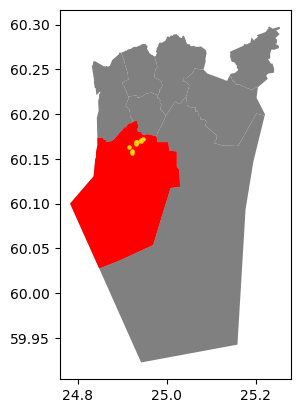

In [18]:
axes = city_districts.plot(facecolor="grey")
southern_district.plot(ax=axes, facecolor="red")

addresses_in_the_southern_district.plot(
    ax=axes,
    color="gold",
    markersize=5
)

Perfect! Now we are left with only the (golden) points which, indeed, are
inside the red polygon. That’s exactly what we wanted!